# Diffusion-augmented conformal prediction
This project explores how to enhance conformal prediction by applying embedding algorithms to the training set and letting each data point borrow conformity information from its neighbors through diffusion. We'll try a few variations of this idea and investigate whether the diffusion helps reduce prediction sets sizes - while maintaining the coverage guarantees.


## Setup
Let's start by importing the libraries we'll need and configure some options.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.set_printoptions(threshold=10)

N_PCA_COMPONENTS = 50
N_NEIGHBORS = 13

We'll also define some useful helpers.

In [2]:
NUM_CLASSES = 10

cifar10_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def cifar10_num2name(num):
    return cifar10_classes[num]

def cifar10_name2num(name):
    return cifar10_classes.index(name)

Next, we define our data loaders. For this project, we'll use the CIFAR-10 image classification dataset. In addition to training, validation and test data partitions, we'll also create a holdout (also known as calibration) data partition for conformal prediction purposes.

In [3]:
HOLDOUT_SIZE = 2000
VALIDATION_SIZE = 5000

transform = T.ToTensor()

full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = len(full_train) - HOLDOUT_SIZE - VALIDATION_SIZE

trainset, validationset, holdoutset = torch.utils.data.random_split(full_train, [train_size, VALIDATION_SIZE, HOLDOUT_SIZE])

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
validationloader = DataLoader(validationset, batch_size=128, shuffle=False)
holdoutloader = DataLoader(holdoutset, batch_size=128, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

## Base model: CNN classifier
Now, we construct a simple CNN classifier. The predictions made by this neural network will be the basis of the conformal predictions.

This particular neural network employs a classic CNN architecture, using a few convolution layers for feature extraction and an MLP head for prediction, with one node per CIFAR-10 class in the output layer. Batch normalization and dropout are applied for regularization.

It is worth noting that *this network is very small*, at least by today's standards. This allows it to train fast, but it naturally means the model will be less performant than larger models. However, this is perfect for our application; recall that the purpose of this project is not to construct a highly accurate image classifier, but rather to use conformal prediction to boost the accuracy (or rather *coverage*) to an arbitrary level. For this purpose, a near-perfect classifier would in fact be counterproductive.

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, NUM_CLASSES)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

Train the network for 20 epochs with cross-entropy as the loss function and Adam as the optimizer. Weight decay is applied as L2 regularization. It is worth noting that we do not explicitly add a softmax function; this is handled by PyTorch's `CrossEntropyLoss` class.

Training on cuda.
Epoch 1/20 - train_loss: 1.4299 - val_loss: 1.1619 - val_acc: 59.60%
Epoch 2/20 - train_loss: 1.0572 - val_loss: 0.9846 - val_acc: 66.30%
Epoch 3/20 - train_loss: 0.9232 - val_loss: 0.9946 - val_acc: 65.30%
Epoch 4/20 - train_loss: 0.8431 - val_loss: 1.0333 - val_acc: 64.60%
Epoch 5/20 - train_loss: 0.7794 - val_loss: 1.0093 - val_acc: 65.78%
Epoch 6/20 - train_loss: 0.7248 - val_loss: 0.8474 - val_acc: 71.16%
Epoch 7/20 - train_loss: 0.6752 - val_loss: 0.9366 - val_acc: 68.30%
Epoch 8/20 - train_loss: 0.6251 - val_loss: 0.9750 - val_acc: 67.26%
Epoch 9/20 - train_loss: 0.5751 - val_loss: 0.8637 - val_acc: 71.32%
Epoch 10/20 - train_loss: 0.5396 - val_loss: 0.8055 - val_acc: 72.90%
Epoch 11/20 - train_loss: 0.5053 - val_loss: 0.7672 - val_acc: 74.38%
Epoch 12/20 - train_loss: 0.4738 - val_loss: 0.8414 - val_acc: 72.56%
Epoch 13/20 - train_loss: 0.4436 - val_loss: 0.7760 - val_acc: 73.78%
Epoch 14/20 - train_loss: 0.3991 - val_loss: 0.8040 - val_acc: 74.06%
Epoch 15/20

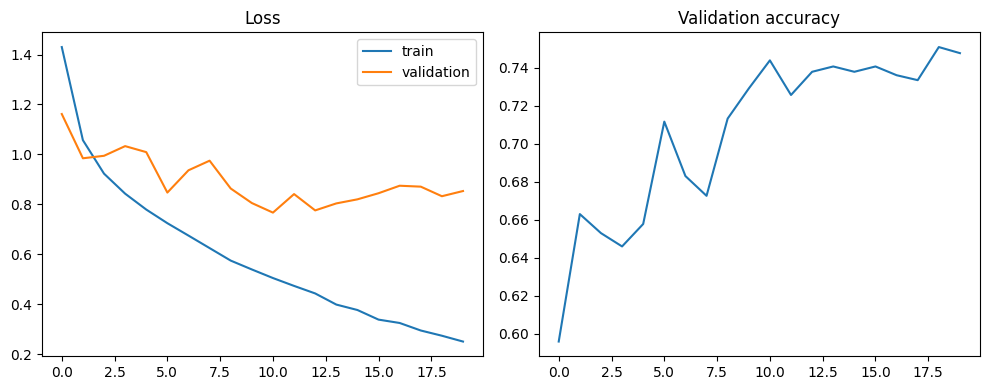

In [5]:
epochs=20
lr=0.0005
savefile="cifar10_smallcnn.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}.")
net = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)

train_losses = []
val_losses = []
val_accs = []

# this should take no longer than a few minutes with cuda
for epoch in range(epochs):
    ### training on training data
    net.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    ### evaluation on validation data
    net.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in validationloader:
            # cross-entropy loss
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_val_loss = val_loss / len(validationloader)
    val_losses.append(avg_val_loss)

    val_acc = correct / total
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{epochs} "
        f"- train_loss: {avg_train_loss:.4f} "
        f"- val_loss: {avg_val_loss:.4f} "
        f"- val_acc: {val_acc*100:.2f}%"
    )

torch.save(net.state_dict(), savefile)

### plot the training
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs)
plt.title("Validation accuracy")

plt.tight_layout()
plt.show()

Finally, let's evaluate the model on the test dataset and see how it performs.

In [6]:
net.eval()  # put the model in eval mode for good; we're done training now

correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(testloader, leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy: 74.74%


We obtain a reasonable performance of around 75% accuracy.

The rest of this notebook will concern itself with applying conformal prediction to the output of this model, boosting its accuracy to arbitrary levels by outputting prediction *sets* rather than single predictions.

## Conformal prediction
Let us first introduce the concept of conformal prediction at a high level. Conformal prediction is a simple, but powerful method of using a model to produce a __prediction set__ that contains the true label with a predefined probability. This is done by reserving a set of *holdout* or *calibration* samples from the training data and computing a *nonconformity score* for each of them - essentially a measure for how poorly the network performed on each holdout sample. Then, an emperical quantile $\hat{q}$ is computed, and this value is used during inference to define a threshold on softmax activations of the output logits of the neural network, determining which of the classes should be included in the prediction set.

The important thing is that conformal prediction gives a __statistical coverage guarantee__ rather than a heuristic notion of confidence (like softmax pseudo-probabilities). For a more rigouors discussion of this topic, we refer to [Conformal Prediction: A Gentle Introduction](http://dx.doi.org/10.1561/2200000101).

Now, we start by implementing *'vanilla'* conformal prediction. By *'vanilla'*, we refer to the standard method *without* the augmentation techniques we'll explore later. This is an important step, because we hope to demonstrate that our techniques yields tighter prediction sets than regular conformal prediction.

To implement conformal prediction, we adapt the code sample provided in [Conformal Prediction: A Gentle Introduction](http://dx.doi.org/10.1561/2200000101).

In [7]:
def get_qhat(alpha=0.1):
    nonconformity_scores = []

    with torch.no_grad():
        for X, y in holdoutloader:
            X, y = X.to(device), y.to(device)
            output = net(X).softmax(dim=1)
            nonconformity_scores.append(1 - output[np.arange(len(y)), y])

        cal_scores = torch.cat(nonconformity_scores).cpu().numpy()
        n = len(cal_scores)
        q_level = np.ceil((n+1)*(1-alpha))/n
        q_hat = np.quantile(cal_scores, q_level, method="higher")
        return q_hat.item()

def get_pred_set(image, q_hat):
    with torch.no_grad():
        val_softmax = net(image.unsqueeze(0)).softmax(dim=1).cpu().numpy()

    pred_set = val_softmax >= (1 - q_hat)
    return np.where(pred_set.squeeze())[0].tolist()  # return list of numbers (e.g. [1, 6] or [3, 4, 8])

Let's check out the threshold value for $\alpha = 0.1$, i.e. a 90% prediction accuracy.

In [8]:
get_qhat(alpha=0.1)

0.9383708834648132

That seems reasonable. Let's try the conformal prediction out on a few test images, setting $\alpha = 0.10$.

  0%|          | 0/25 [00:00<?, ?it/s]

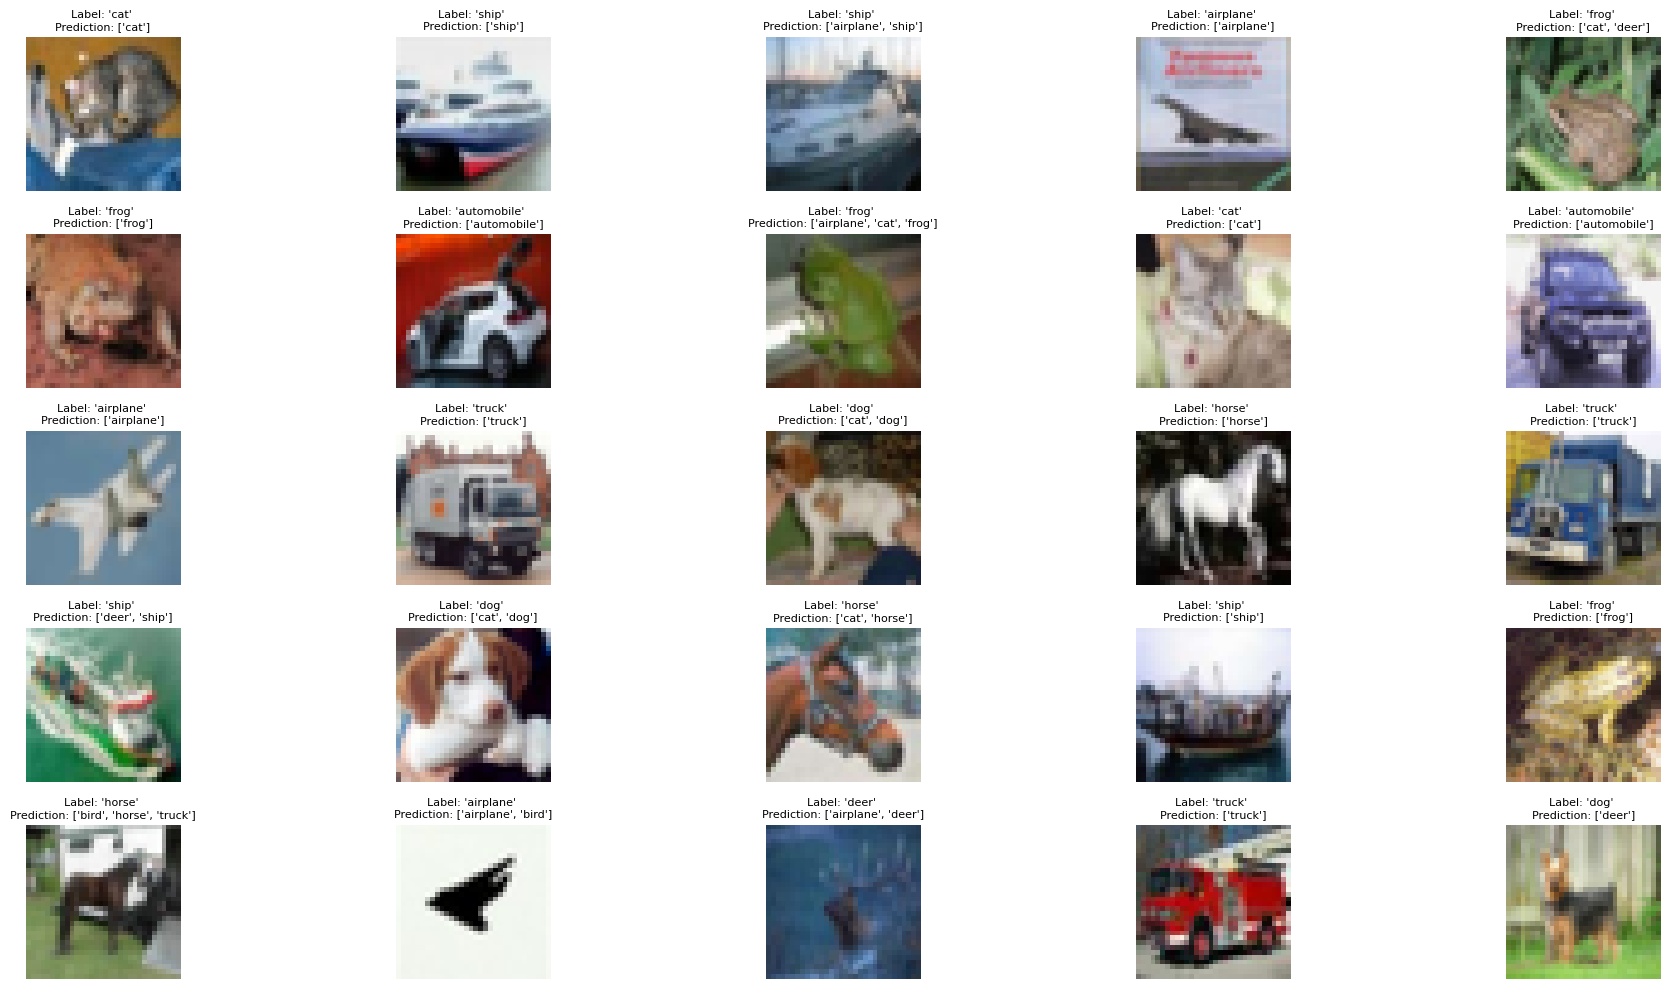

In [9]:
# get a batch of test images
test_images, test_labels = next(iter(testloader))

n = 25
rows, cols = 5, 5
plt.figure(figsize=(20, 10))

alpha = 0.10
q_hat = get_qhat(alpha)

for i in tqdm(range(n), leave=False):
    img = test_images[i]
    label = test_labels[i].item()

    pred_set = get_pred_set(img.to(device), q_hat)

    plt.subplot(rows, cols, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Label: {repr(cifar10_num2name(label))} \nPrediction: {[cifar10_num2name(p) for p in pred_set]}", fontsize=8)

plt.tight_layout()
plt.show()

It's working! The predictions are sets and the correct label is almost always part of the prediction set. When the model is uncertain, the sets include 2 or more classes, and when the model is sufficiently certain, the prediction set is a singleton.

Let's try out the conformal prediction on the entire test set and collect some metrics. We should get very close to 90% coverage.


In [10]:
correct, total = 0, 0
avg_set_size = 0
with torch.no_grad():
    for images, labels in tqdm(testloader, leave=False):
        images, labels = images.to(device), labels.to(device)
        for i in range(len(images)):
            pred_set = get_pred_set(images[i], q_hat)
            avg_set_size += len(pred_set)
            if any(p == labels[i] for p in pred_set):
                correct += 1
            total += 1

print(f"q_hat: {q_hat}")
print(f"Accuracy (CP): {100 * correct / total:.2f}%")
print(f"Average set size: {avg_set_size / total:.2f}")

  0%|          | 0/79 [00:00<?, ?it/s]

q_hat: 0.9383708834648132
Accuracy (CP): 89.54%
Average set size: 1.67


Conformal prediction is working as intended!

Clearly, tight prediction sets are more useful than wide ones; it's far more helpful to say `the estimated value is between $3,100 and $3,300` than it is to say `the estimated value is between $2,000 and $5,000`. As such, we're not concerned with improving the *coverage*, because we can already configure that to an arbitrary level. Rather, we're concerned with *decreasing the size of prediction sets*. This is what we will focus on for the rest of this notebook.

## Augmented conformal prediction
To improve the prediction sets, we will apply embedding algorithms to the training set and exploit the similarity of data points (in this case, images) that are neighbors in the embedding space. Our hope is that this will result in more efficient predictions (i.e. tighter prediction sets). The idea is based on [Conformal Prediction Sets for Graph Neural Networks](https://proceedings.mlr.press/v202/h-zargarbashi23a.html), a recent article by Soroush H. Zargarbashi, Simone Antonelli and Aleksandar Bojchevski.

Let us discuss the details a bit further before we continue to the implementation. We have a dataset partitioned into training data, validation data, test data, and *holdout data*, also referred to as *calibration data*. In standard conformal prediction, we would compute a nonconformity score $s_i$ for each calibration data point $(X_i, Y_i)$ in the following manner:

$$
s_i = 1 - \sigma(f(X_i))_{Y_i}
$$

where $\sigma$ denotes the softmax function and $f$ is the output layer of our neural network. That is, the nonconformity score is 1 minus the softmax pseudo-probability of the correct class.

In our embedding approach, we will do something else. Using the training data, we construct an embedding. Then, we compute the nonconformity score using both the nonconformity of each calibration point itself *and* its nearest neighbors in the training data embedding, weighted by their distance to the calibration sample.

$$
\hat{s}_i = (1 - \lambda) s_i + \lambda\sum_{j \in \mathcal{N}_i}w_{ij}\cdot s_j,
$$

where the normalized weights $w_{ij}$ are defined by
$$
w_{ij} = \frac{\hat{w}_{ij}}{\sum_{k \in \mathcal{N}_i}\hat{w}_{ik}} \qquad \hat{w}_{ij} = \frac{1}{d_{ij}+\epsilon}
$$

Here, $\lambda \in [0, 1]$ is a parameter that controls the balance between the sample score $s_i$ and the weighted score of its neighbors $\mathcal{N}_i$.

The remaining question is then: *how do we construct this embedding?* There are multiple way of doing so. Below, we will explore three different approaches.

#### Principal Component Analysis (PCA)
As the first and simplest method, we will apply *Principal Component Analysis (PCA)* to the raw images in training set.

In [11]:
train_feats = []
train_scores = []  # precompute all nonconformity scores
labels = []

with torch.no_grad():
    for X, y in tqdm(trainloader, leave=False):
        X, y = X.to(device), y.to(device)

        # add flattened images for PCA analysis
        train_feats.append(X.view(X.size(0), -1))

        # softmax probabilities
        probs = F.softmax(net(X), dim=1)   # (B, C)

        # nonconformity scores for all classes
        scores = 1.0 - probs.detach().cpu().numpy()   # (B, C)
        train_scores.append(scores)

        # save labels for plotting
        labels.append(y.view(X.size(0), -1))

train_feats = torch.cat(train_feats, dim=0).cpu().numpy()
train_scores = np.concatenate(train_scores, axis=0)
labels = torch.cat(labels, dim=0).cpu().numpy()

  0%|          | 0/168 [00:00<?, ?it/s]

We then perform the PCA analysis and plot the first two principal components to get a feel for the embedding space. The colors indicate the CIFAR-10 classes.

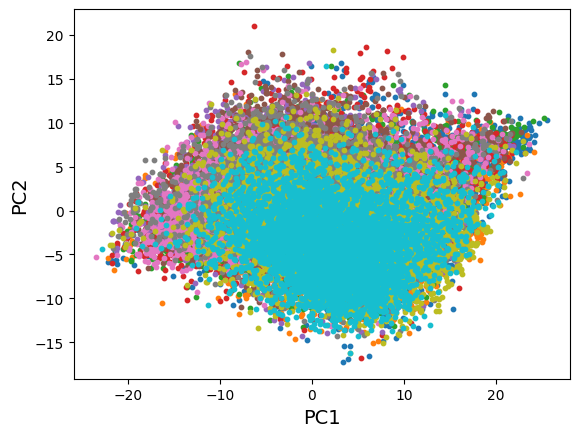

In [12]:
pca = PCA(n_components=N_PCA_COMPONENTS)
pca_embeddings = pca.fit_transform(train_feats)

pca_nn_model = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm="auto")
pca_nn_model.fit(pca_embeddings)

def pca_embed_single_image(image):
    emb = pca.transform(image.view(1, -1).cpu().numpy())
    return emb[0]

for class_id in range(NUM_CLASSES):
    idxs = labels[:, 0] == class_id
    plt.scatter(pca_embeddings[idxs, 0], pca_embeddings[idxs, 1], s=10)
    plt.xlabel('PC1', fontsize=14)
    plt.ylabel('PC2', fontsize=14)
plt.show()

Now, we are ready to define the diffusion scoring functions.

In [13]:
@torch.no_grad()
def diffused_scores_for_image(x_tensor, lam):
    if x_tensor.dim() == 3:
        x = x_tensor.unsqueeze(0).to(device)
    else:
        x = x_tensor.to(device)

    # base scores from model softmax
    probs = F.softmax(net(x), dim=1)[0].cpu().numpy()
    base_scores = 1.0 - probs

    # PCA embedding for neighbor lookup
    emb = pca_embed_single_image(x)

    # get K nearest neighbors in embedding space
    distances, neigh_idx = pca_nn_model.kneighbors([emb], return_distance=True)
    distances = distances[0]
    neigh_idx = neigh_idx[0]

    # retrieve neighbor scores (already precomputed)
    neigh_scores = train_scores[neigh_idx]

    # smaller distance => larger weight
    inv_dist = 1.0 / (distances + 1e-8)
    weights = inv_dist / inv_dist.sum()  # normalized, sum to 1

    # weighted neighbor average
    mean_neigh = (neigh_scores * weights[:, None]).sum(axis=0)

    # final diffused score per class
    diffused = (1.0 - lam) * base_scores + lam * mean_neigh

    return diffused

@torch.no_grad()
def get_qhat_diffused(alpha=0.1, lam=0.1):
    diff_scores_true = []

    for X, y in tqdm(holdoutloader, leave=False):
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)

        for i in range(batch_size):
            s_hat = diffused_scores_for_image(X[i], lam=lam)
            true_label = y[i].item()
            diff_scores_true.append(s_hat[true_label])

    diff_scores_true = np.array(diff_scores_true)
    n = len(diff_scores_true)
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_hat = np.quantile(diff_scores_true, q_level, method="higher")
    return float(q_hat)

@torch.no_grad()
def get_pred_set_diffused(x, q_hat_diff, lam=0.1):
    s_hat = diffused_scores_for_image(x, lam=lam)
    pred_set = [c for c in range(NUM_CLASSES) if s_hat[c] <= q_hat_diff]
    return pred_set

Let's now compute the diffused and non-diffused $\hat{q}$ scores.

In [14]:
ALPHA  = 0.10
LAMBDA = 0.10

print("Computing q_hat for diffused CP...")
q_hat_vanilla = get_qhat(alpha=ALPHA)
print(f"q_hat (vanilla): {q_hat_vanilla:.4f}")

print("Computing q_hat for diffused CP...")
q_hat_diff = get_qhat_diffused(alpha=ALPHA, lam=LAMBDA)
print(f"q_hat (diffused): {q_hat_diff:.4f}")

Computing q_hat for diffused CP...
q_hat (vanilla): 0.9384
Computing q_hat for diffused CP...


  0%|          | 0/16 [00:00<?, ?it/s]

q_hat (diffused): 0.9257


 Finally, let's do a test on the test data and see how the PCA augmentation compares to vanilla conformal prediction.

In [15]:
total = 0
correct_top1 = 0

covered_std, covered_diff = 0, 0
size_std_sum, size_diff_sum = 0.0, 0.0

with torch.no_grad():
    for X, y in tqdm(testloader, leave=False):
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)

        probs = F.softmax(net(X), dim=1)
        top1 = probs.argmax(dim=1)
        correct_top1 += (top1 == y).sum().item()

        for i in range(batch_size):
            true_label = y[i].item()

            # vanilla CP set
            pred_std = get_pred_set(X[i], q_hat_vanilla)

            # diffused CP set
            pred_diff = get_pred_set_diffused(X[i], q_hat_diff, lam=LAMBDA)

            # update counters
            if true_label in pred_std:
                covered_std += 1
            if true_label in pred_diff:
                covered_diff += 1

            size_std_sum += len(pred_std)
            size_diff_sum += len(pred_diff)

        total += batch_size

top1_acc      = correct_top1 / total
coverage_std  = covered_std / total
coverage_diff = covered_diff / total
avg_size_std  = size_std_sum / total
avg_size_diff = size_diff_sum / total

print(f"Top-1 accuracy (plain softmax):     {top1_acc:.4f}")
print(f"Coverage (vanilla CP):              {coverage_std:.4f}")
print(f"Coverage (diffused CP):             {coverage_diff:.4f}")
print(f"Avg set size (vanilla CP):          {avg_size_std:.4f}")
print(f"Avg set size (diffused CP):         {avg_size_diff:.4f}")

  0%|          | 0/79 [00:00<?, ?it/s]

Top-1 accuracy (plain softmax):     0.7474
Coverage (vanilla CP):              0.8954
Coverage (diffused CP):             0.8956
Avg set size (vanilla CP):          1.6725
Avg set size (diffused CP):         1.6757


Unfortunately, it seems __we see no improvement__ over vanilla conformal prediction using our PCA embedding. The average prediction set size is roughly the same.

Perhaps the problem is that this diffusion is little more than noise. PCA on the raw image data captures no semantic information, and thus the diffusion adds little helpful information. We will now investigate whether a different kind of embedding that captures semantic information yields better results.

#### Convolutional layers + PCA
Now, we investigate an extension to the PCA approach described in last section. We conjectured that perhaps the PCA embedding did not capture useful information, reducing the diffusion step to mere noise. Now, we will attempt to better capture the information in the image, and thereby produce a better embedding.

As it happens, we already have a way of capturing semantic information in the image - that is exactly the purpose of the convolutional layers in the image classifier! We can feed the output of the convolutional layers to the PCA analysis rather than the raw image, and hopefully we'll obtain better results. This is quite convenient, because it requires no extra training.

First, we define a helper function to apply only the convolutional layers of the CNN model.

In [16]:
@torch.no_grad()
def extract_conv_features(x):
    x = net.conv1(x)
    x = net.conv2(x)
    x = x.view(x.size(0), -1)
    return x.detach().cpu().numpy()

We then construct the embedding.

In [17]:
train_feats = []
train_scores = []  # precompute all nonconformity scores
labels = []

with torch.no_grad():
    for X, y in tqdm(trainloader, leave=False):
        X, y = X.to(device), y.to(device)

        # conv features
        feats = extract_conv_features(X)
        train_feats.append(feats)

        # softmax probabilities
        probs = F.softmax(net(X), dim=1)   # (B, C)

        # nonconformity scores for all classes
        scores = 1.0 - probs.detach().cpu().numpy()   # (B, C)
        train_scores.append(scores)

        # save labels for plotting
        labels.append(y.view(X.size(0), -1))

train_feats = np.concatenate(train_feats, axis=0)
train_scores = np.concatenate(train_scores, axis=0)
labels = torch.cat(labels, dim=0).cpu().numpy()

  0%|          | 0/168 [00:00<?, ?it/s]

Rather than use the raw output of the convolutional layers, we apply PCA (for dimensionality reduction) to obtain the final embedding. Let us again plot the first two principal component to get a feel for the embedding space.

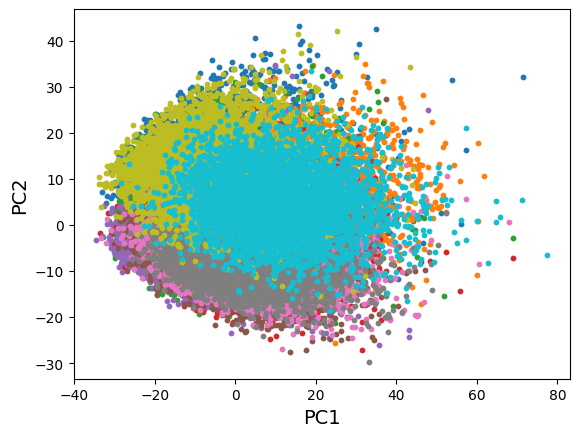

In [18]:
cnn_pca = PCA(n_components=N_PCA_COMPONENTS)
cnn_embed = cnn_pca.fit_transform(train_feats)

cnn_nn_model = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm="auto")
cnn_nn_model.fit(cnn_embed)

def cnn_embed_single_image(x_tensor):
    with torch.no_grad():
        features = extract_conv_features(x_tensor)
        emb = cnn_pca.transform(features)
    return emb[0]

for class_id in range(NUM_CLASSES):
    idxs = labels[:, 0] == class_id
    plt.scatter(cnn_embed[idxs, 0], cnn_embed[idxs, 1], s=10)
    plt.xlabel('PC1', fontsize=14)
    plt.ylabel('PC2', fontsize=14)
plt.show()

This embedding appears more promising than the raw PCA embedding, but there is still a lot of overlap between classes.

We overwrite the `diffused_scores_for_image`. The other scoring functions remain the same.

In [19]:
@torch.no_grad()
def diffused_scores_for_image(x_tensor, lam):
    if x_tensor.dim() == 3:
        x = x_tensor.unsqueeze(0).to(device)
    else:
        x = x_tensor.to(device)

    # base scores from model softmax
    probs = F.softmax(net(x), dim=1)[0].cpu().numpy()
    base_scores = 1.0 - probs

    # CNN embedding for neighbor lookup
    emb = cnn_embed_single_image(x)

    # get K nearest neighbors in embedding space
    distances, neigh_idx = cnn_nn_model.kneighbors([emb], return_distance=True)
    distances = distances[0]
    neigh_idx = neigh_idx[0]

    # retrieve neighbor scores (already precomputed)
    neigh_scores = train_scores[neigh_idx]

    # smaller distance => larger weight
    inv_dist = 1.0 / (distances + 1e-8)
    weights = inv_dist / inv_dist.sum()  # normalized, sum to 1

    # weighted neighbor average
    mean_neigh = (neigh_scores * weights[:, None]).sum(axis=0)

    # final diffused score per class
    diffused = (1.0 - lam) * base_scores + lam * mean_neigh

    return diffused

Let's now compute the diffused and non-diffused $\hat{q}$ scores and see how the CNN augmentation compares to vanilla conformal prediction.

In [21]:
ALPHA  = 0.1
LAMBDA = 0.1

print("Computing q_hat for diffused CP...")
q_hat_vanilla = get_qhat(alpha=ALPHA)
print(f"q_hat (vanilla): {q_hat_vanilla:.4f}")

print("Computing q_hat for diffused CP...")
q_hat_diff = get_qhat_diffused(alpha=ALPHA, lam=LAMBDA)
print(f"q_hat (diffused): {q_hat_diff:.4f}")

total = 0
correct_top1 = 0

covered_std, covered_diff = 0, 0
size_std_sum, size_diff_sum = 0.0, 0.0

with torch.no_grad():
    for X, y in tqdm(testloader, leave=False):
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)

        probs = F.softmax(net(X), dim=1)
        top1 = probs.argmax(dim=1)
        correct_top1 += (top1 == y).sum().item()

        for i in range(batch_size):
            true_label = y[i].item()

            # vanilla CP set
            pred_std = get_pred_set(X[i], q_hat_vanilla)

            # diffused CP set
            pred_diff = get_pred_set_diffused(X[i], q_hat_diff, lam=LAMBDA)

            # update counters
            if true_label in pred_std:
                covered_std += 1
            if true_label in pred_diff:
                covered_diff += 1

            size_std_sum += len(pred_std)
            size_diff_sum += len(pred_diff)

        total += batch_size

top1_acc      = correct_top1 / total
coverage_std  = covered_std / total
coverage_diff = covered_diff / total
avg_size_std  = size_std_sum / total
avg_size_diff = size_diff_sum / total

print(f"Top-1 accuracy (plain softmax):     {top1_acc:.4f}")
print(f"Coverage (vanilla CP):              {coverage_std:.4f}")
print(f"Coverage (diffused CP):             {coverage_diff:.4f}")
print(f"Avg set size (vanilla CP):          {avg_size_std:.4f}")
print(f"Avg set size (diffused CP):         {avg_size_diff:.4f}")

Computing q_hat for diffused CP...
q_hat (vanilla): 0.9384
Computing q_hat for diffused CP...


  0%|          | 0/16 [00:00<?, ?it/s]

q_hat (diffused): 0.9235


  0%|          | 0/79 [00:00<?, ?it/s]

Top-1 accuracy (plain softmax):     0.7474
Coverage (vanilla CP):              0.8954
Coverage (diffused CP):             0.8980
Avg set size (vanilla CP):          1.6725
Avg set size (diffused CP):         1.6581


__We obtain improved results!__

Using this embedding, we obtain slightly improved prediction sets while maintaining the coverage guarantee. The improvement is modest, but this is a very promising result.

#### Deep embedding models
We now attempt one final approach. We employ a pretrained transformer-based vision model: [DINOv2](https://github.com/facebookresearch/dinov2).

Arguably, this can be considered "cheating" - we're outsourcing some of the classification task to a larger, better model.

First, we load the model.

In [29]:
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dino_model.to(device)
dino_model.eval()

dino_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


We apply the model on the training set. This will take a few minutes.


In [31]:
# if you get impatient (or run out of GPU memory)
# you can decrease MAX_SAMPLES
MAX_SAMPLES = 25000

train_feats = []
train_scores = []
labels = []

sample_count = 0
with torch.no_grad():
    for X, y in tqdm(trainloader, leave=False):
        X, y = X.to(device), y.to(device)

        # DINO features
        feats = dino_model(dino_transform(X))
        train_feats.append(feats)

        # softmax probabilities
        probs = F.softmax(net(X), dim=1)

        # nonconformity scores for all classes
        scores = 1.0 - probs.detach().cpu().numpy()
        train_scores.append(scores)

        # save labels for plotting
        labels.append(y.view(X.size(0), -1))

        sample_count += X.size(0)
        if sample_count > MAX_SAMPLES:
            break

train_feats = torch.cat(train_feats, dim=0).cpu().numpy()
train_scores = np.concatenate(train_scores, axis=0)
labels = torch.cat(labels, dim=0).cpu().numpy()
print(f"Finished processing {len(train_feats)} samples.")

  0%|          | 0/168 [00:00<?, ?it/s]

Finished processing 25088 samples.


We once again define a PCA and plot it.

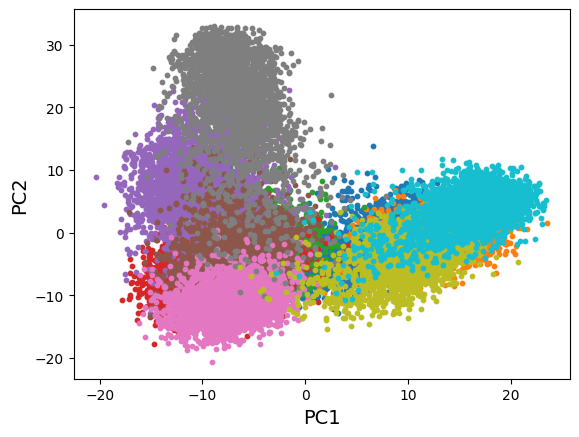

In [24]:
dino_pca = PCA(n_components=N_PCA_COMPONENTS)
dino_embed = dino_pca.fit_transform(train_feats)

dino_nn_model = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm="auto")
dino_nn_model.fit(dino_embed)

def dino_embed_single_image(x_tensor):
    with torch.no_grad():
        dino_output = dino_model(dino_transform(x_tensor)).cpu().numpy()
        emb = dino_pca.transform(dino_output)
    return emb[0]

for class_id in range(NUM_CLASSES):
    idxs = labels[:, 0] == class_id
    plt.scatter(dino_embed[idxs, 0], dino_embed[idxs, 1], s=10)
    plt.xlabel('PC1', fontsize=14)
    plt.ylabel('PC2', fontsize=14)
plt.show()

In this embedding, we see a substantially clearer division between the various classes. DINOv2 does a much better job of capturing the semantic information in the images than the convolutional layer of our small CNN classifier.

We overwrite `diffused_scores_for_image` again.

In [27]:
@torch.no_grad()
def diffused_scores_for_image(x_tensor, lam):
    if x_tensor.dim() == 3:
        x = x_tensor.unsqueeze(0).to(device)
    else:
        x = x_tensor.to(device)

    # base scores from model softmax
    probs = F.softmax(net(x), dim=1)[0].cpu().numpy()
    base_scores = 1.0 - probs

    # DINO embedding for neighbor lookup
    emb = dino_embed_single_image(x)

    # get K nearest neighbors in PCA embedding space
    distances, neigh_idx = dino_nn_model.kneighbors([emb], return_distance=True)
    distances = distances[0]
    neigh_idx = neigh_idx[0]

    # retrieve neighbor scores (already precomputed)
    neigh_scores = train_scores[neigh_idx]

    # smaller distance => larger weight
    inv_dist = 1.0 / (distances + 1e-8)
    weights = inv_dist / inv_dist.sum()  # normalized, sum to 1

    # weighted neighbor average
    mean_neigh = (neigh_scores * weights[:, None]).sum(axis=0)

    # final diffused score per class
    diffused = (1.0 - lam) * base_scores + lam * mean_neigh

    return diffused

Let's compute the diffused and non-diffused $\hat{q}$ scores and see how the DINOv2-based augmentation compares to vanilla conformal prediction.

In [28]:
ALPHA  = 0.1
LAMBDA = 0.1

print("Computing q_hat for diffused CP...")
q_hat_vanilla = get_qhat(alpha=ALPHA)
print(f"q_hat (vanilla): {q_hat_vanilla:.4f}")

print("Computing q_hat for diffused CP...")
q_hat_diff = get_qhat_diffused(alpha=ALPHA, lam=LAMBDA)
print(f"q_hat (diffused): {q_hat_diff:.4f}")

total = 0
correct_top1 = 0

covered_std, covered_diff = 0, 0
size_std_sum, size_diff_sum = 0.0, 0.0

with torch.no_grad():
    for X, y in tqdm(testloader, leave=False):
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)

        probs = F.softmax(net(X), dim=1)
        top1 = probs.argmax(dim=1)
        correct_top1 += (top1 == y).sum().item()

        for i in range(batch_size):
            true_label = y[i].item()

            # vanilla CP set
            pred_std = get_pred_set(X[i], q_hat_vanilla)

            # diffused CP set
            pred_diff = get_pred_set_diffused(X[i], q_hat_diff, lam=LAMBDA)

            # update counters
            if true_label in pred_std:
                covered_std += 1
            if true_label in pred_diff:
                covered_diff += 1

            size_std_sum += len(pred_std)
            size_diff_sum += len(pred_diff)

        total += batch_size

top1_acc      = correct_top1 / total
coverage_std  = covered_std / total
coverage_diff = covered_diff / total
avg_size_std  = size_std_sum / total
avg_size_diff = size_diff_sum / total

print(f"Top-1 accuracy (plain softmax):     {top1_acc:.4f}")
print(f"Coverage (vanilla CP):              {coverage_std:.4f}")
print(f"Coverage (diffused CP):             {coverage_diff:.4f}")
print(f"Avg set size (vanilla CP):          {avg_size_std:.4f}")
print(f"Avg set size (diffused CP):         {avg_size_diff:.4f}")

Computing q_hat for diffused CP...
q_hat (vanilla): 0.9384
Computing q_hat for diffused CP...


  0%|          | 0/16 [00:00<?, ?it/s]

q_hat (diffused): 0.8742


  0%|          | 0/79 [00:00<?, ?it/s]

Top-1 accuracy (plain softmax):     0.7474
Coverage (vanilla CP):              0.8954
Coverage (diffused CP):             0.8970
Avg set size (vanilla CP):          1.6725
Avg set size (diffused CP):         1.4393


This DINOv2-powered embedding gives us a __significantly__ better prediction set. However, we should keep in mind that this method relies on a large external model. Presumably, similar or greater performance gains could have been achieved by simply using a correspondingly larger base model to begin with.

## Conclusion
In this notebook, we architected and trained a CNN image classifer on the CIFAR-10 dataset and showed how its coverage could be boosted to arbitrary levels using conformal prediction.

We then explored three different approaches to creating an embedding space for the training data and applying diffusion to nonconformity scores to obtain more efficient (tighter!) prediction sets. We found that:

- an embedding based on raw PCA yielded no improvement.
- an embedding based on the convolutional layers of the classifier yielded a modest, but real improvement.
- an embedding based on DINOv2 yielded a major improvement.

Of course, all these augmentations (particularly the last one) come at the cost of an increased computational load during inference.